<a href="https://colab.research.google.com/github/njones61/ce544/blob/main/docs/unit1/09_dewatering/dewatering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construction Dewatering

This notebook is used to design dewatering systems for excavations in unconfined aquifers. It uses well equations to calculate the drawdown for a series of dewatering wells. The excavation size and location are specified using GeoJSON file. To create a geojson file of a region of interest, go here:

https://geojson.io/#map=2.85/32.25/-98.07

and zoom in on a region of interest. Then use the draw polygon tool to draw your region. When you are done, select the Save option and save your polygon to a geojson file

In [3]:
%%capture
!pip install geopandas
!pip install ipyleaflet

In [2]:
from ipyleaflet import Map, Polygon, Marker, DrawControl, GeoJSON, LayerGroup
from ipywidgets import HTML
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
import pyproj
from shapely.geometry import shape, Point, Polygon


In [ ]:
# Upload GEOJSON file
from google.colab import files
uploaded = files.upload()

# get name of uploaded file
file_name = list(uploaded.keys())[0]

Saving byu_brewster.geojson to byu_brewster.geojson


In [ ]:
# Load GEOJSON for Polygon and extract coordinates
geojson_file = file_name  # path to your GEOJSON file
polygon_data = gpd.read_file(geojson_file)
geojson_data = polygon_data.__geo_interface__
polygon_coords = list(polygon_data.geometry[0].exterior.coords)  # Extract exterior coords

# swap the orders of the pairs in polygon_coords
polygon_coords = [(y, x) for x, y in polygon_coords]


In [ ]:
polygon_coords

[(40.246851678806706, -111.64554864779842),
 (40.24610895796758, -111.6455446101439),
 (40.24610895796758, -111.64368728911117),
 (40.246854760619016, -111.6436953644202),
 (40.246851678806706, -111.64554864779842)]

In [ ]:
# Create a polygon using the polygon_coords that I can add to an ipyleaflet map
polygon = GeoJSON(
    data=geojson_data,
    style={
        'color': 'blue',
        'fillColor': 'gray',
        'fillOpacity': 0.2,
        'weight': 2
    }
)

center = [polygon_data.geometry[0].centroid.y, polygon_data.geometry[0].centroid.x]
m = Map(center=center, zoom=18)
m.add(polygon)

# Create a DrawControl for user to click and add markers
draw_control = DrawControl(marker={"shapeOptions": {"color": "#0000FF"}})

# Store marker coordinates
marker_coords = []

# Function to add markers and store their coordinates
def handle_marker(event=None, action=None, geo_json=None):
    if action == 'created' and geo_json['geometry']['type'] == 'Point':
        lat, lng = geo_json['geometry']['coordinates'][1], geo_json['geometry']['coordinates'][0]
        marker_coords.append((lat, lng))  # Store each marker's coordinates
        marker = Marker(location=(lat, lng), draggable=False)
        m.add_layer(marker)

# Attach the marker handler to draw control
draw_control.on_draw(handle_marker)
m.add_control(draw_control)

# Display map
m

Map(center=[40.24648095523502, -111.64461833588719], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
# OPTIONAL - Delete the markers from the map
for marker in m.layers[2:]:
    m.remove_layer(marker)
marker_coords = []

In [ ]:
nw = len(marker_coords) #count the number of wells
print(f"Number of Wells: {nw}")
marker_coords

Number of Wells: 4


[(40.246896, -111.645593),
 (40.246905, -111.643694),
 (40.245992, -111.645593),
 (40.246008, -111.643705)]

# Drawdown Calculations

![confined aquifer](https://ce544.groups.et.byu.net/images/unconfined.png)

$
h = \sqrt{H^{2} - \frac{1}{\pi k} \sum_{i=1}^n q_{i}ln\left(R/r\right)}
$

## Functions used in this section

In [ ]:
# Define functions for this section

def sum_well_h(r):
  return np.sqrt(H**2 - (1/(np.pi*k))*np.sum(qi*np.log(R/r)))

def build_grid(well_coords, poly_coords):

  # Create grid of points
  cushion = 0.3 # Fraction of distance to add to each side when creating grid
  num_points = 100  # Modify for resolution

  well_lats, well_lons = zip(*well_coords)
  poly_lats, poly_lons = zip(*poly_coords)
  latitudes = list(well_lats) + list(poly_lats)
  longitudes = list(well_lons) + list(poly_lons)
  lat_range = max(latitudes) - min(latitudes)
  lon_range = max(longitudes) - min(longitudes)
  lat_cushion = lat_range * cushion
  lon_cushion = lon_range * cushion
  min_lat = min(latitudes) - lat_cushion
  max_lat = max(latitudes) + lat_cushion
  min_lon = min(longitudes) - lon_cushion
  max_lon = max(longitudes) + lon_cushion

  grid_lat = np.linspace(min_lat, max_lat, num_points)
  grid_lon = np.linspace(min_lon, max_lon, num_points)
  grid_lat, grid_lon = np.meshgrid(grid_lat, grid_lon)

  # Transform from lat/lon to x, y coordinates in meters
  transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857")
  poly_x, poly_y = transformer.transform(poly_lats, poly_lons)
  grid_x, grid_y = transformer.transform(grid_lat, grid_lon)
  wells_x, wells_y = transformer.transform(well_lats, well_lons)

  # Convert wells_x and wells_y to NumPy arrays
  wells_x = np.array(wells_x)
  wells_y = np.array(wells_y)

  # Reshape wells_x and wells_y to be compatible with broadcasting
  wells_x = wells_x[:, np.newaxis, np.newaxis]  # Shape: (nw, 1, 1)
  wells_y = wells_y[:, np.newaxis, np.newaxis]  # Shape: (nw, 1, 1)

  # Calculating Distances: The distances array will now have shape (nw, 100, 100), representing the
  # distances from each of the nw wells to each point on the 100x100 grid.
  distances = np.sqrt((grid_x[np.newaxis, ...] - wells_x)**2 + (grid_y[np.newaxis, ...] - wells_y)**2)

  return distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y

def contour_plot(heads, well_coords, poly_coords, binary=False, binary_value=0):
  # Plot contours using matplotlib
  plt.figure(figsize=(12, 4))

  # if binary = True, use two color bands, one above binary value and one below, otherwise use defaults
  if binary:
    # Find the minimum and maximum values in heads, excluding NaN and Inf
    valid_values = heads[np.isfinite(heads)]
    min_val = np.min(valid_values)
    max_val = np.max(valid_values)

    # Ensure binary_value is within the range of valid values
    binary_value = np.clip(binary_value, min_val, max_val)

    # Adjust levels based on binary_value and data range
    levels = [min_val, binary_value, max_val]
    plt.contourf(grid_lon, grid_lat, heads, levels=levels, colors=['red', 'blue'], extend='both')
  else:
    plt.contourf(grid_lon, grid_lat, heads, cmap=cm.viridis)

  plt.colorbar(label='Computed Values')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')

  # use an equal aspect
  plt.gca().set_aspect('equal')

  well_lats, well_lons = zip(*well_coords)
  poly_lats, poly_lons = zip(*poly_coords)

  # add the marker_coords to the map as scatter points
  plt.scatter(well_lons, well_lats, color='red', marker='o', s=100)

  # add the poly_coords to the map as dashed lines
  plt.plot(poly_lons, poly_lats, color='black', linestyle='--', linewidth=2)

  plt.show()

def filter_inside_polygon(h_grid, grid_x, grid_y, poly_x, poly_y):

  poly_coords_shapely = Polygon(list(zip(poly_x, poly_y)))
  num_points = len(grid_x[0])
  grid_points = [Point(grid_x[i][j], grid_y[i][j]) for i in range(num_points) for j in range(num_points)]
  inside_poly = [poly_coords_shapely.contains(grid_points[i]) for i in range(num_points * num_points)]
  inside_poly = np.array(inside_poly).reshape(num_points, num_points)

  # use the inside_poly results to create a filter of h_grid so that all values outside of poly are nans
  return np.where(inside_poly, h_grid, np.nan)

def objective_function(h_grid_inside, design_head):
  max_h = np.max(h_grid_inside)
  diff =  design_head - h_grid_inside
  return diff # Should be zero if max head in excavation is right at the bottom

## Calculations

In [ ]:
#@markdown ### **Enter variables used in analysis**
#@markdown Enter k in [cm/s], everything else in [m]

k_cms = 0.0005 #@param
k = k_cms / 100

H = 40 #@param
R = 500 #@param

design_head = 35 #@param

total_Q = 0.010 #@param
qi = total_Q / nw

In [ ]:
# distances has a shape of (nw, 100, 100). Call the h function for all values of nw to return a (100, 100) set of results in h_grid

distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(marker_coords, polygon_coords)

h_grid = np.apply_along_axis(sum_well_h, 0, distances)


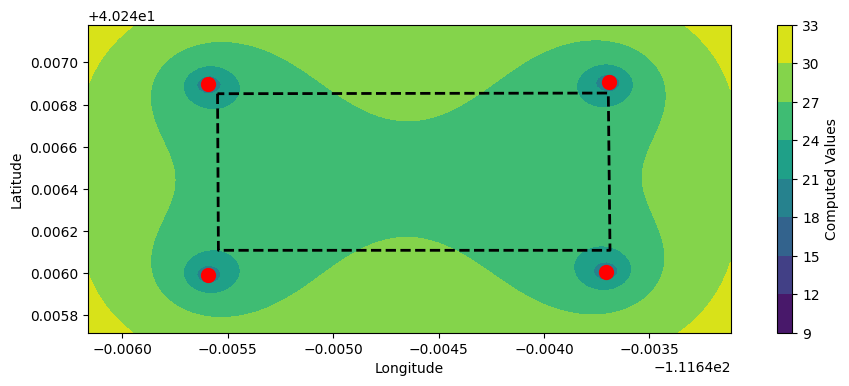

In [ ]:
contour_plot(h_grid, marker_coords, polygon_coords)


In [ ]:
h_grid_inside = filter_inside_polygon(h_grid, grid_x, grid_y, poly_x, poly_y)

In [ ]:
# print the max value of h_grid_inside
print(f"Max value of h_grid_inside: {np.nanmax(h_grid_inside)}")

Max value of h_grid_inside: 29.978155831979663


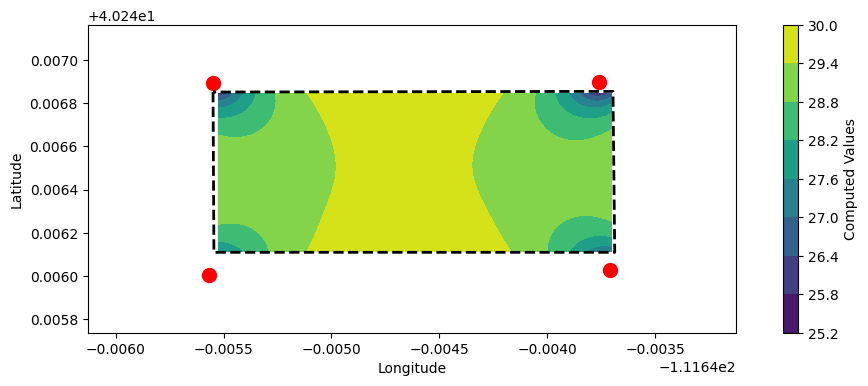

In [ ]:
contour_plot(h_grid_inside, marker_coords, polygon_coords)

In [ ]:
# create a new head array which is the h_grid minus design_head
h_grid_new = h_grid_inside - design_head

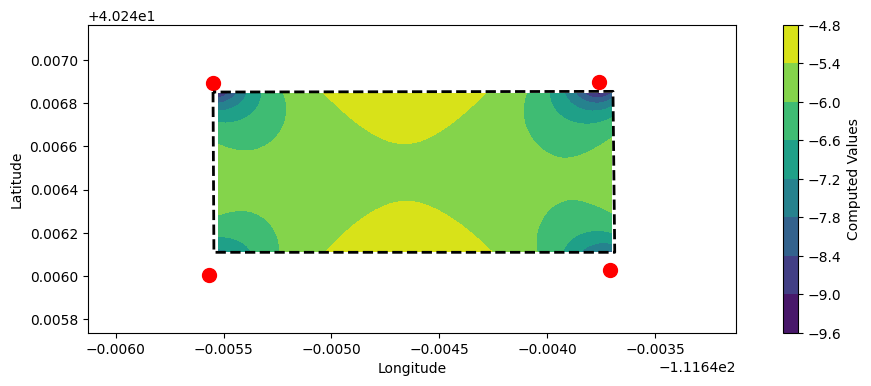

In [ ]:
contour_plot(h_grid_new, marker_coords, polygon_coords)

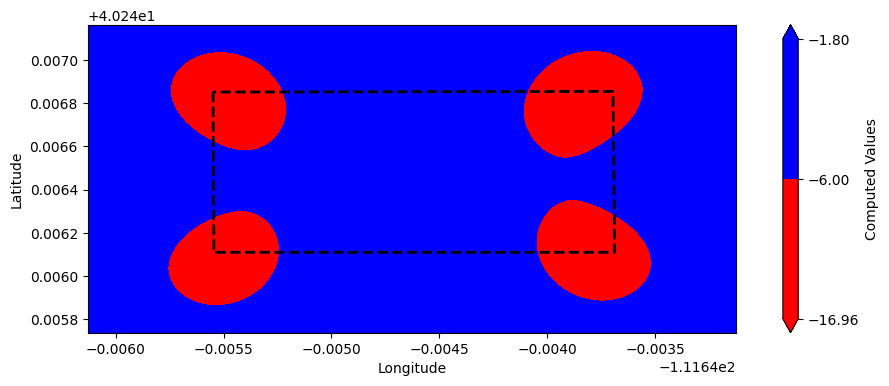

In [ ]:
h_split = h_grid-design_head

contour_plot(h_split,marker_coords, polygon_coords, binary=True, binary_value=-6)

# Rectangular Well System Design

In this section we will generate a set of wells along a rectangle that is offset from the bounding box of the excavation.

## Define functions for this section

In [ ]:
def parse_geojson(geojson_data):
    # Parse GeoJSON to extract polygon coordinates
    geo_shape = shape(geojson_data['features'][0]['geometry'])
    if isinstance(geo_shape, Polygon):
        return list(geo_shape.exterior.coords)
    else:
        raise ValueError("GeoJSON does not contain a polygon.")

def project_coordinates(coords, transformer):
    # Project lat/lon to meters
    projected = []
    for lon, lat in coords:
        try:
            x, y = transformer.transform(lon, lat)
            projected.append((x, y))
        except Exception as e:
            print(f"Error projecting coordinate ({lat}, {lon}): {e}")
            projected.append((float('inf'), float('inf')))
    return projected

def generate_well_locations_geojson(geojson_data, offset_m, npts_x):

    from pyproj import Transformer

    # Step 1: Parse GeoJSON and get polygon coordinates
    polygon_coords = parse_geojson(geojson_data)

    #print("Parsed Coordinates (Lat/Lon):", polygon_coords)

    # Step 2: Set up a general-purpose transformer (EPSG:3857)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    inverse_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

    # Project polygon to meters
    projected_polygon = project_coordinates(polygon_coords, transformer)
    #print("Projected Coordinates (Meters):", projected_polygon)

    # Ensure there are valid projected coordinates
    if any(x == float('inf') or y == float('inf') for x, y in projected_polygon):
        raise ValueError("Projection failed for some coordinates. Please check input data and projection settings.")

    # Step 3: Compute bounding box in meters
    x_coords, y_coords = zip(*projected_polygon)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    #print("Bounding Box (Meters):", min_x, max_x, min_y, max_y)

    # Step 4: Expand the bounding box by the offset in meters
    min_x -= offset_m
    max_x += offset_m
    min_y -= offset_m
    max_y += offset_m

    # Step 5: Generate well locations along the expanded bounding box
    wells = []

    # Calculate spacing for east-west points
    spacing_x = (max_x - min_x) / (npts_x - 1)

    # Calculate the number of points in the north-south direction
    npts_y = int(round((max_y - min_y) / spacing_x)) + 1
    spacing_y = (max_y - min_y) / (npts_y - 1)

    print(f"Spacing in X: {spacing_x}")
    print(f"Spacing in Y: {spacing_y}")

    # Generate points along the bottom (south) edge
    for i in range(npts_x):
        x = min_x + i * spacing_x
        wells.append((x, min_y))

    # Generate points along the right (east) edge
    for i in range(1, npts_y - 1):  # Avoid corners
        y = min_y + i * spacing_y
        wells.append((max_x, y))

    # Generate points along the top (north) edge
    for i in range(npts_x):
        x = max_x - i * spacing_x
        wells.append((x, max_y))

    # Generate points along the left (west) edge
    for i in range(1, npts_y - 1):  # Avoid corners
        y = max_y - i * spacing_y
        wells.append((min_x, y))

    # Step 6: Convert well coordinates back to lat/lon
    well_coords_latlon = [(inverse_transformer.transform(x, y)) for x, y in wells]

    return well_coords_latlon

## Calculations

In [ ]:
offset_m = 20
npts_x = 5
rect_wells_coords = generate_well_locations_geojson(geojson_data, offset_m, npts_x)

# swap the orders of the pairs in well_coords
rect_wells_coords = [(y, x) for x, y in rect_wells_coords]

num_wells = len(rect_wells_coords)
print(f"Number of Wells: {num_wells}")

Spacing in X: 61.80137531179935
Spacing in Y: 74.38582569779828
Number of Wells: 12


In [ ]:
qi = total_Q / num_wells

distances, grid_lat, grid_lon, grid_x, grid_y, poly_x, poly_y = build_grid(rect_wells_coords, polygon_coords)

h_grid = np.apply_along_axis(sum_well_h, 0, distances)

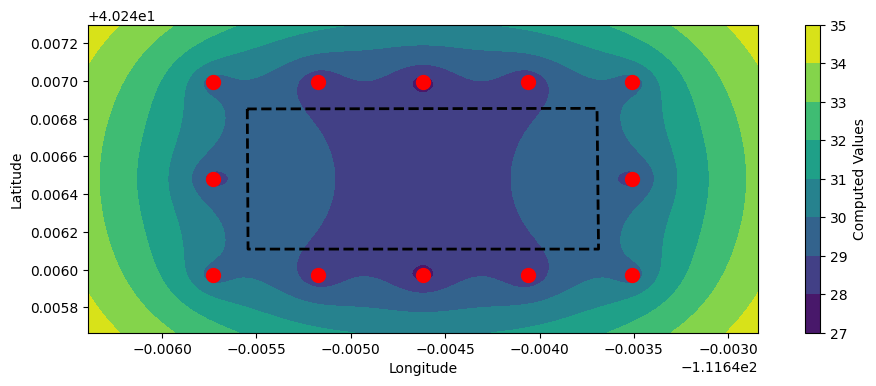

In [ ]:
contour_plot(h_grid, rect_wells_coords, polygon_coords)